In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing libraries
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

In [ ]:
# checking if a gpu is available if not use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
# class to visualize the images with asl
class visualisation_asl():
  def load_image(self, image_path):
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        image = Image.open(image_path)
        image = transform(image) #transforming data
        image = image.unsqueeze(0)  # adding batch dimension (batch size = 1)
        image = image.to(device)  # ensuring  the image is on the correct device
        return image

  def plot_image(self, image, label):
        image = image.cpu() # Move the tensor to CPU before converting to NumPy
        image = np.squeeze(image.numpy())  # Convert tensor to NumPy array
        plt.figure(figsize=(1.5, 3))
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

visualisation = visualisation_asl()

In [ ]:
# creating dictionary of the labels and respective letters
# it helps to identify if we correctly show label and its respective image
alph_dict = {
  0: 'A',
  1: 'B',
  2: 'C',
  3: 'D',
  4: 'E',
  5: 'F',
  6: 'G',
  7: 'H',
  8: 'I',
  9: 'J',
  10: 'K',
  11: 'L',
  12: 'M',
  13: 'N',
  14: 'O',
  15: 'P',
  16: 'Q',
  17: 'R',
  18: 'S',
  19: 'T',
  20: 'U',
  21: 'V',
  22: 'W',
  23: 'X',
  24: 'Y',
  25: 'Z'
  }

In [ ]:
class ASLDataLoader():
    # DataLoader class for loading and preprocessing ASL dataset
    train_path = "/content/drive/MyDrive/asl/sign_mnist_train.csv"
    test_path = "/content/drive/MyDrive/asl/sign_mnist_test.csv"
    batch_size = 64
    def _init_(self, train_path, test_path, batch_size):
      # initializing paths and batch size
        self.train_path = train_path
        self.test_path = test_path
        self.batch_size = batch_size

    def load_data(self):
      # loading dataset from csv file
        df = pd.read_csv(self.train_path)
        df_test = pd.read_csv(self.test_path)
        return df, df_test

    def preprocess_data(self, df, df_test):
      # reshaping  normalising and splitting the data
        X = df.drop('label', axis=1).values
        X = X.reshape(-1, 1, 28, 28).astype('float32') / 255.0
        y = df['label'].values

        X_test = df_test.drop('label', axis=1).values
        X_test= X_test.reshape(-1, 1, 28, 28).astype('float32') / 255.0
        y_test = df_test['label'].values

        # splitting the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def create_dataloaders(self):
      # craeting dataloader onjects for training, validation and test set
        df, df_test = self.load_data()
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = self.preprocess_data(df, df_test)

        train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
        test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

        return train_loader, val_loader, test_loader

In [ ]:
# Template Pattern: Abstarct base class for asl model
class ASLModel(ABC, nn.Module):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def forward(self, x):
      # abstract method for forward pass
        pass

    @abstractmethod
    def train_model(self, train_loader, criterion, optimizer, epochs):
      # abstract method for training model
        pass

    def predict(self, image):
      #method for making predictions
        self.eval()
        with torch.no_grad():
            return self.forward(image)


In [ ]:
# Strategy Pattern: Different model implementation - CNN
class CNNModel(ASLModel):
    def __init__(self):
        super().__init__()
        # defining cnn layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 25)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
      # defining forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def train_model(self, train_loader,criterion, optimizer, num_epochs,device, observer=None):
      #training function
        train_losses, val_losses, val_accuracy = [], [],[]
        for epoch in range(num_epochs):
          running_loss = 0.0

          # train loop
          for images, labels in train_loader:
              images, labels = images.to(device), labels.to(device)
              # zero the parameter gradients
              optimizer.zero_grad()
              # forward pass
              outputs = model(images)
              # calculating the loss
              loss = criterion(outputs, labels)
              #backward pass and optimization
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

          # calculating and storing the average training loss for the current epoch
          train_loss = running_loss / len(train_loader)
          train_losses.append(train_loss)


          # Validation loop
          val_running_loss = 0.0
          # disabling gradient computation during validation
          with torch.no_grad():
            # iterating through validation data
              total = 0
              correct = 0
              for images, labels in val_loader:
                  images, labels = images.to(device), labels.to(device)
                  outputs = model(images)
                  # calculating validation loss
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  val_running_loss += loss.item()

          # calculating and storing the average validation loss for the current epoch
          val_loss = val_running_loss / len(val_loader)
          val_accuracy = 100 * correct / total
          val_losses.append(val_loss)

          # implementing observer pattern for logging results
          if observer:
            observer.update(epoch, val_loss,val_accuracy)

        # implementing observer pattern for graph visualisation
        observer.train_val_graph(val_losses, train_losses)


    def predict(model, image):
         model.eval()
         with torch.no_grad():
          image = image.to(device)
          outputs = model(image)
          _ , predicted = torch.max(outputs, 1)
         return predicted.item()

In [ ]:
# Strategy Pattern: Different model implementation - Resnet
class ResNetModel(ASLModel):
    def __init__(self):
      #using pretrained resnet18 model
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        # altering first layer of trained model to adjust to the data classes and grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_model(self, train_loader, criterion, optimizer, num_epochs, device, observer=None):
        train_losses, val_losses, val_accuracies = [], [], []

        for epoch in range(num_epochs):
            running_loss = 0.0

            # training loop
            self.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # validation loop
            val_running_loss = 0.0
            correct, total = 0, 0
            self.eval()
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.forward(images)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_running_loss += loss.item()

            val_loss = val_running_loss / len(val_loader)
            val_accuracy = 100 * correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # implementing observer pattern for logging results
            if observer:
                observer.update(epoch, val_loss, val_accuracy)

        # implementing observer pattern for graph visualisation
        observer.train_val_graph(val_losses, train_losses)

    def predict(model, image):
         model.eval()
         with torch.no_grad():
          image = image.to(device)
          outputs = model(image)
          _ , predicted = torch.max(outputs, 1)
         return predicted.item()


In [ ]:
# Factory Pattern: Model Factory fro selecting model type : either CNN or ResNet
class ModelFactory:
    @staticmethod
    def get_model(model_type):
        if model_type == "CNN":
            return CNNModel()
        elif model_type == "ResNet":
            return ResNetModel()
        else:
            raise ValueError("Unknown model type")


In [ ]:
# Observer Pattern: Training observer to monitor model training and validation
class EvalObserver:
    def update(self, epoch, loss,accuracy):
      # printing validation loss and accuracy per epoch
        print(f"Validation Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")

    def train_val_graph(self,val_losses, train_losses):
      # plotting training and validation loss over epochs
      plt.figure(figsize=(10,5))
      plt.plot(train_losses, label='Training Loss')
      plt.plot(val_losses, label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training and Validation Loss')
      plt.legend()
      plt.show()


observer = EvalObserver()

In [ ]:
# evaluating model perfromance on test data
def test_model():
  model.eval()
  total_test = 0
  correct_test = 0

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels= images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()

  # calculating testing accuracy
  test_accuracy = 100 * correct_test / total_test
  print(f'Test Accuracy: {test_accuracy:.2f}%')

Validation Epoch: 0, Loss: 0.7887646555900574, Accuracy: 78.23711527954835
Validation Epoch: 1, Loss: 0.3101740777492523, Accuracy: 90.38426516117283
Validation Epoch: 2, Loss: 0.1194913387298584, Accuracy: 95.15570934256056
Validation Epoch: 3, Loss: 0.2853541076183319, Accuracy: 96.99508286286651
Validation Epoch: 4, Loss: 0.01584278978407383, Accuracy: 97.72354762338372
Validation Epoch: 5, Loss: 0.03570830076932907, Accuracy: 97.63248952831907
Validation Epoch: 6, Loss: 0.08483108878135681, Accuracy: 98.03314514660353
Validation Epoch: 7, Loss: 0.010376258753240108, Accuracy: 98.63412857403023
Validation Epoch: 8, Loss: 0.01982479728758335, Accuracy: 99.10763066836641
Validation Epoch: 9, Loss: 0.004693904425948858, Accuracy: 98.94372609725005


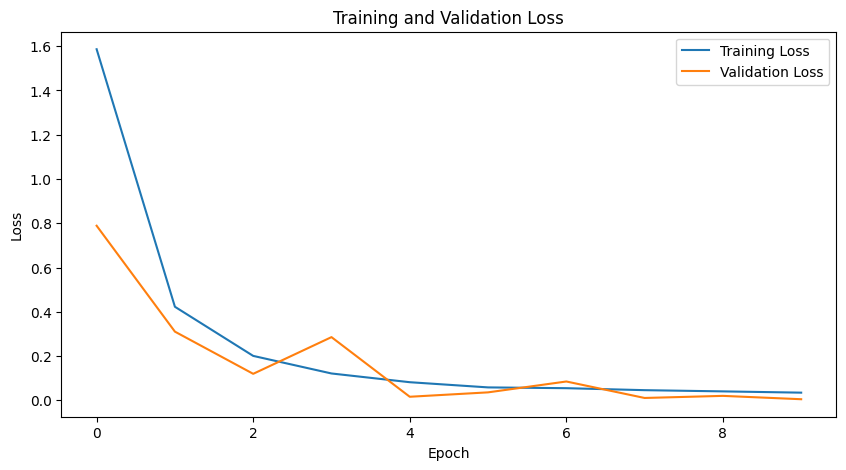

Test Accuracy: 93.29%
11
Predicted class: L


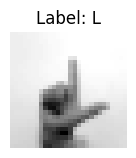

In [ ]:
# running the ASL model training and evaluation
if __name__ == "__main__":
    # initialising the asl data loader
    data_loader = ASLDataLoader()

    # creating DataLoaders for training, validation, and testing
    train_loader, val_loader, test_loader = data_loader.create_dataloaders()

    # initiating the model using the factory pattern
    model = ModelFactory.get_model("CNN")

    # defining optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

     # training  the model with specified parameters
    model.train_model(train_loader, criterion, optimizer, num_epochs=10,device=device, observer=observer)

     # evaluating the model on the test dataset
    test_model()

     # loading an example image for prediction
    image_path = '/content/drive/MyDrive/asl/sign_images/L.jpeg'
    letter = image_path.split("/")[-1].split(".")[0]

    # loading the image using visualization utilities
    image = visualisation.load_image(image_path)

    # predicting the class label of the image using the trained model
    prediction = model.predict(image)
    print(f'Predicted class: {alph_dict[prediction]}')

     # displaying the image along with its true label
    visualisation.plot_image(image, letter)